In [1]:
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path='malgun.ttf'
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

import seaborn as sns
plt.rcParams["font.family"] = 'NanumGothic'
rc('font', weight='bold')
%matplotlib inline

In [3]:
def file_load():
    rating_data=pd.read_excel('viewer_rate.xlsx', header=1, index_col='시간대')
    train_data=pd.read_excel('performance.xlsx', header=1)
    test_data=pd.read_excel('performance_test.xlsx', header=1)
    
    return rating_data, train_data, test_data

def col_rename(fir_train_data, fir_test_data):
    sec_train_data = fir_train_data.rename(columns={'방송일시':'time','노출(분)':'exp_min', '마더코드':'m_code',
                           '상품코드':'p_code','상품명':'p_name','상품군':'p_cate',
                           '판매단가':'p_price','취급액':'target'}, inplace=False)
    
    sec_test_data = fir_test_data.rename(columns={'방송일시':'time','노출(분)':'exp_min', '마더코드':'m_code',
                           '상품코드':'p_code','상품명':'p_name','상품군':'p_cate',
                           '판매단가':'p_price','취급액':'target'}, inplace=False)

    return sec_train_data, sec_test_data

def time_split(time):
    year=time.year
    month=time.month
    day=time.day
    hour=time.hour
    minute=time.minute
    date=time.weekday()
    
    return pd.Series([year, month, day, hour, minute, date])

In [4]:
def preprocess(train_data, test_data):
    
    # rename columns
    train_data, test_data = col_rename(train_data, test_data)
    
    # seperate dates
    train_data[['year','month','day','hour','minute','date']]=train_data['time'].apply(time_split)
    test_data[['year','month','day','hour','minute','date']]=test_data['time'].apply(time_split)
    
    # fillna
    train_data['exp_min']=train_data['exp_min'].fillna(method='ffill')
    test_data['exp_min']=test_data['exp_min'].fillna(method='ffill')
    train_data['target']=train_data['target'].fillna(0)
    test_data['target']=test_data['target'].fillna(0)
    
    # transfer to 'int'
    train_data['exp_min']=train_data.exp_min.astype(int)
    test_data['exp_min']=test_data.exp_min.astype(int)
    train_data['target']=train_data.target.astype(int)
    test_data['target']=test_data.target.astype(int)
    
    train_data['orders']=train_data['target']/train_data['p_price']
    test_data['orders']=test_data['target']/test_data['target']
    
    return train_data, test_data

In [5]:
fir_rating_data, fir_train_data, fir_test_data = file_load()

In [6]:
train_data, test_data = preprocess(fir_train_data, fir_test_data)


* * *

In [7]:
group_mcode = train_data.groupby('m_code')

In [8]:
find_diff1=pd.DataFrame(group_mcode['p_price'].min()==group_mcode['p_price'].max())
find_diff2=find_diff1.reset_index()
find_diff3=pd.Series(find_diff2[find_diff2['p_price']==False].m_code.values)
find_diff4=pd.Series(find_diff2[find_diff2['p_price']==True].m_code.values)

In [9]:
def separate_by_price(train_data):
    columns=['time','exp_min','m_code','p_code','p_name','p_cate','p_price','target','year','month','day','hour','minute']
    diff_price_mcode=pd.DataFrame(columns=columns)
    same_price_mcode=pd.DataFrame(columns=columns)
    
    for value in find_diff3:
        diff_price_mcode=diff_price_mcode.append(train_data.loc[train_data['m_code']==value], ignore_index=False)
        
    for value in find_diff4:
        same_price_mcode=same_price_mcode.append(train_data.loc[train_data['m_code']==value], ignore_index=False)
        
    return diff_price_mcode, same_price_mcode

In [10]:
diff_price_mcode, same_price_mcode = separate_by_price(train_data)

In [11]:
diff_group_mcode=diff_price_mcode.groupby('m_code')

* * *

In [12]:
# top 10 mcode (counts)
def all_top10_mcode(train_data):
    group_mcode = train_data.groupby('m_code')
    all_top10_mcode = group_mcode.count().sort_values('time', ascending=False).head(10).index
    
    return pd.Series(all_top10_mcode)

# clothes top 10 mcode (counts)
def cloth_top10_mcode(train_data):
    cloth_data = train_data[train_data['p_cate']=='의류']
    group_mcode = cloth_data.groupby('m_code')
    cloth_top10_mcode = group_mcode.count().sort_values('time', ascending=False).head(10).index
    
    return pd.Series(cloth_top10_mcode)

# 가장 많이 / 적게 팔린 pcode 종목 모두 추출
def top_bot_pcode(mcode):
        top_mcode = group_mcode.get_group(mcode)
        group_pcode=top_mcode.groupby('p_code')
        top_pcode = group_pcode.target.mean().sort_values(ascending=False).index[0]
        bot_pcode = group_pcode.target.mean().sort_values(ascending=True).index[0]
        top_pcode_value = group_pcode.get_group(top_pcode).sort_values('target',ascending=False)
        bot_pcode_value = group_pcode.get_group(bot_pcode).sort_values('target',ascending=False)
        
        return top_pcode_value, bot_pcode_value

# 가장 많이 / 적게 팔린 pcode 5개씩 추출
def concated_pcode(mcode):
    top_pcode, bot_pcode = top_bot_pcode(mcode)
    top_pcode_value = top_pcode.head(5)
    bot_pcode_value = bot_pcode.tail(5)
    concated_pcode = pd.concat([top_pcode_value, bot_pcode_value], axis=0)
    
    return concated_pcode

 - top : 같은 m_code 중에서 target의 평균이 가장 높은 p_code
 - bot : 같은 m_code 중에서 target의 평균이 가장 낮은 p_code
 - concated_pcode : 해당 p_code 들의 상세한 종목
 
### Okaaay
* * *

# p_code

In [42]:
def date_count(mcode):
    top, bot = top_bot_pcode(mcode)
    a=top.date.value_counts().sort_index()
    b=bot.date.value_counts().sort_index()
    c=pd.concat([a,b], axis=1)
    c.columns=['top_pcode','bot_pcode']
    return c

def pcode_target_plot(value):
    c=date_count(value)
    d=train_data[train_data['m_code']==value]['p_name'].values[0]
    c.plot(kind='bar', figsize=(10,5), color=['skyblue', 'orange'])
    plt.title(d, size=15)
    plt.xlabel('date', size=15)
    plt.ylabel('count', size=15)

In [43]:
top10_mcode=pd.Series(all_top10_mcode(train_data))

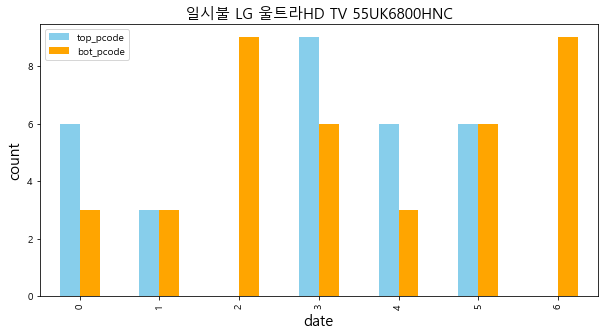

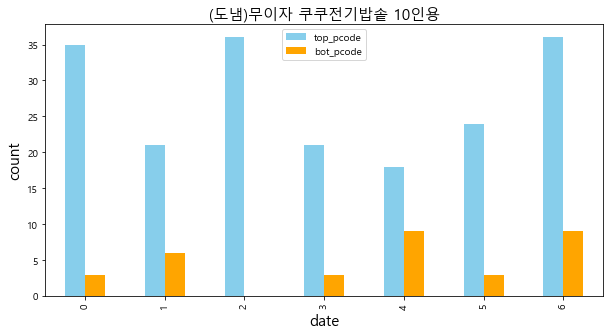

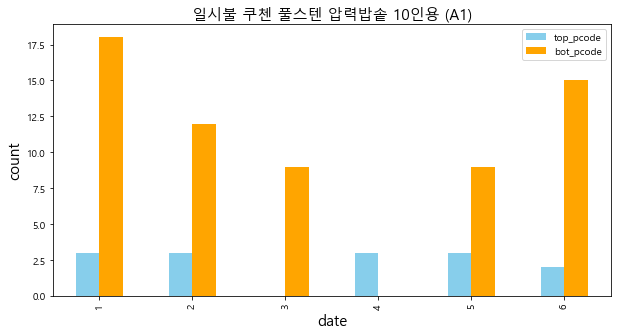

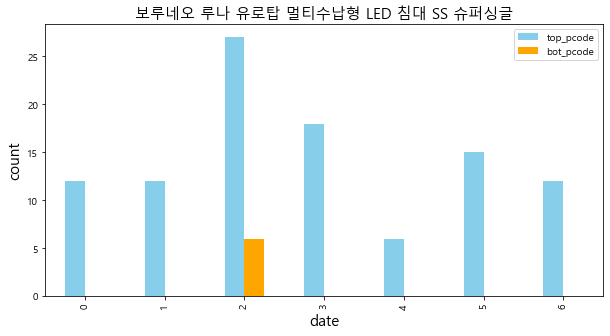

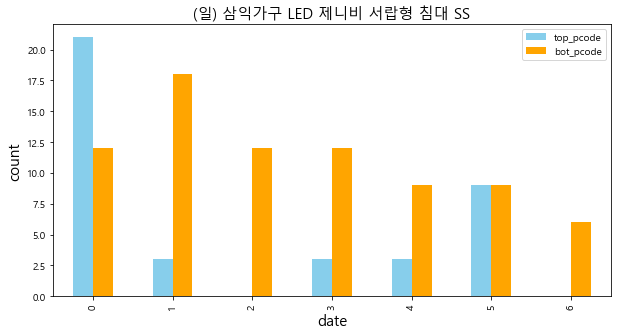

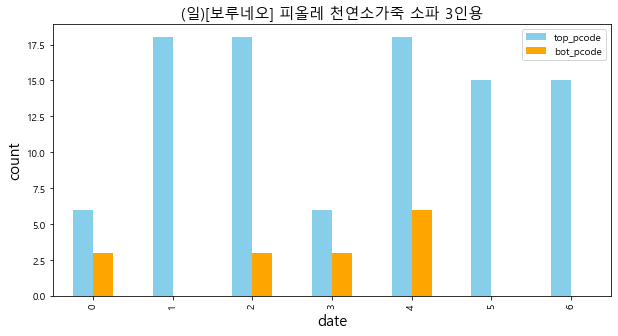

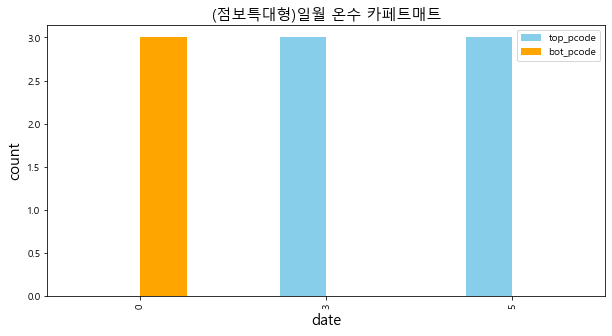

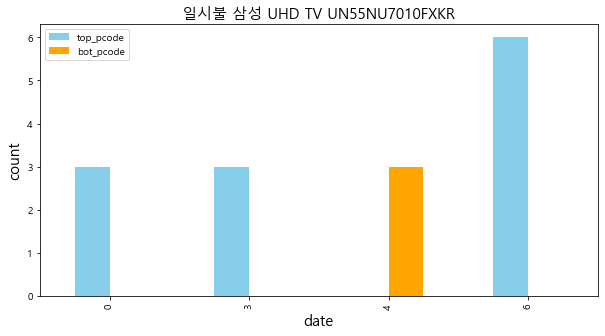

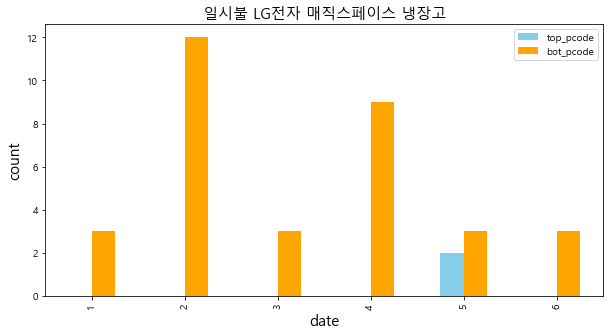

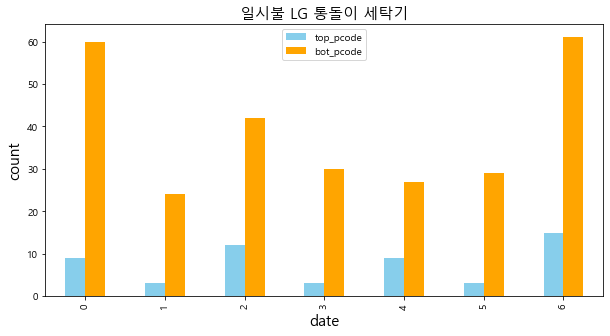

In [44]:
for values in top10_mcode:
    pcode_target_plot(values)

* * *

In [294]:
cloth_top10_mcode=pd.Series(cloth_top10_mcode(train_data))

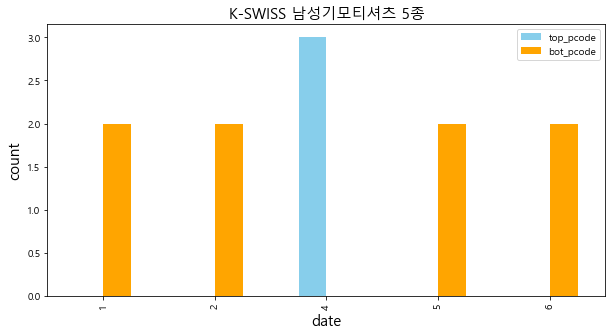

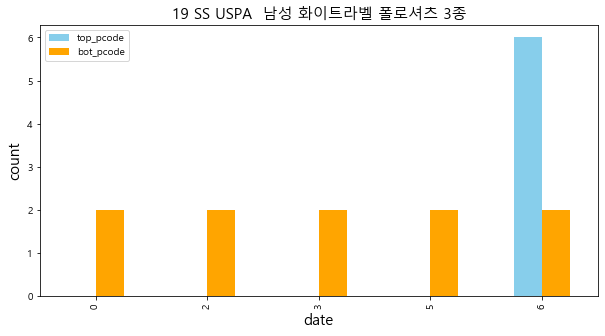

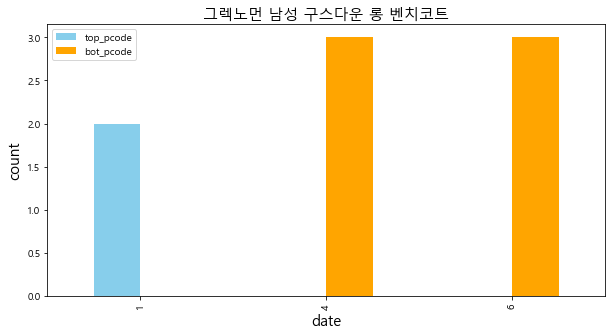

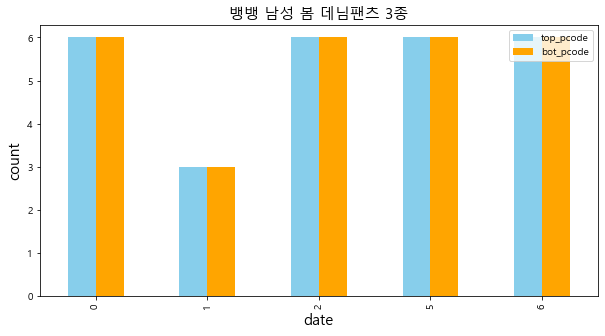

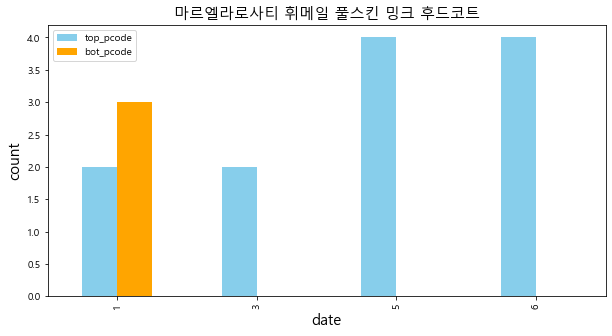

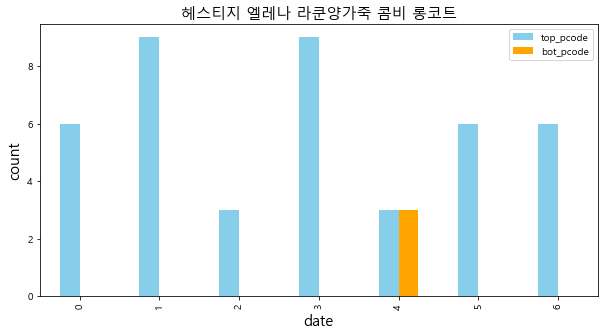

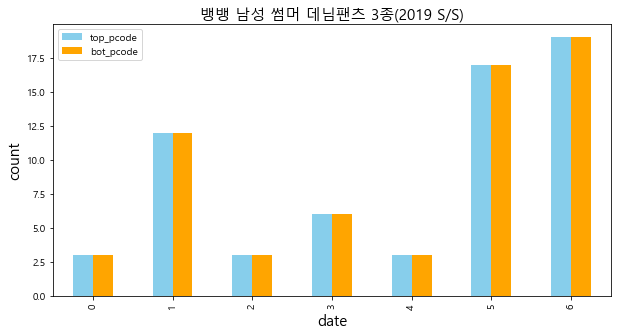

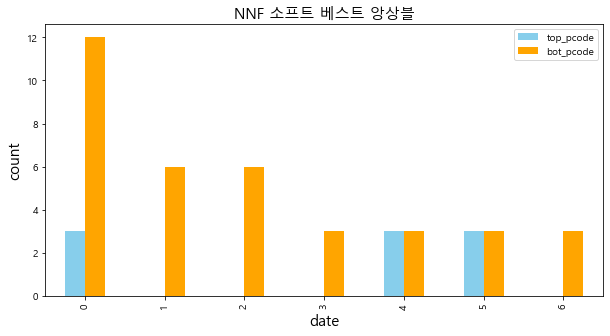

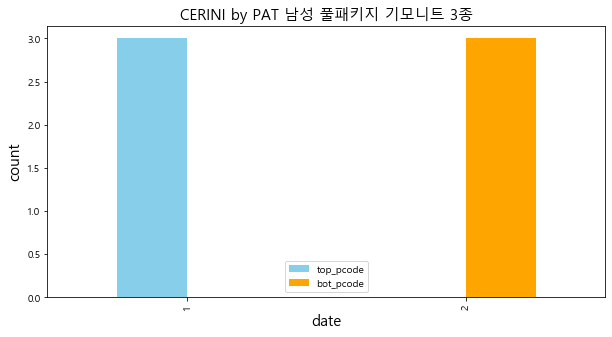

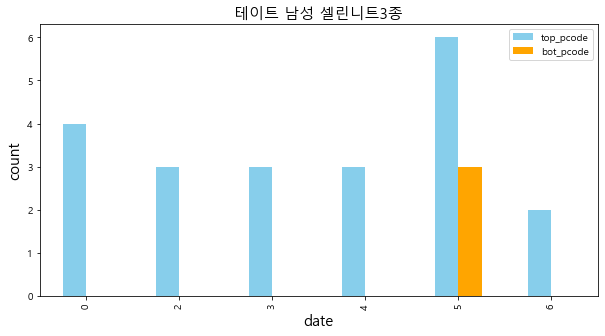

In [297]:
for values in cloth_top10_mcode:
    plot(values)

In [59]:
concated_pcode(100125)

,time,exp_min,m_code,p_code,p_name,p_cate,p_price,target,year,month,day,hour,minute,date,orders
12646,2019-05-02 16:40:00,20,100125,200333,네페르티티 유기농 퀸 석류즙 6박스,건강기능,77000,25903000,2019,5,2,16,40,3,336.402597
12645,2019-05-02 16:20:00,20,100125,200333,네페르티티 유기농 퀸 석류즙 6박스,건강기능,77000,23052000,2019,5,2,16,20,3,299.376623
12644,2019-05-02 16:00:00,20,100125,200333,네페르티티 유기농 퀸 석류즙 6박스,건강기능,77000,15812000,2019,5,2,16,0,3,205.350649
8663,2019-03-29 13:40:00,20,100125,200334,네페르티티 유기농 퀸 석류즙 6박스,건강기능,79000,22232000,2019,3,29,13,40,4,281.417722
8662,2019-03-29 13:20:00,20,100125,200334,네페르티티 유기농 퀸 석류즙 6박스,건강기능,79000,15555000,2019,3,29,13,20,4,196.898734
8661,2019-03-29 13:00:00,20,100125,200334,네페르티티 유기농 퀸 석류즙 6박스,건강기능,79000,10036000,2019,3,29,13,0,4,127.037975


# Price

In [46]:
def top_bot_price2(mcode):
    top_mcode = group_mcode.get_group(mcode)
    group_price = top_mcode.groupby('p_price')
    top_price = group_price.target.mean().sort_values(ascending=False).index[0]
    bot_price = group_price.target.mean().sort_values(ascending=True).index[0]
    top_price_value = group_price.get_group(top_price).sort_values('target',ascending=False)
    bot_price_value = group_price.get_group(bot_price).sort_values('target',ascending=False)
        
    return top_price_value, bot_price_value

# 가장 많이 / 적게 팔린 p_price 5개씩 추출
def concated_price(mcode):
    top_price, bot_price = top_bot_price2(mcode)
    top_price_value = top_price.head(5)
    bot_price_value = bot_price.tail(5)
    concated_price = pd.concat([top_price_value, bot_price_value], axis=0)
    
    return concated_price

In [56]:
def top_bot_price(mcode):
    top_mcode = group_mcode.get_group(mcode)
    group_price = top_mcode.groupby('p_price')
    top_price = group_price.target.mean().sort_values(ascending=False).index[:5]
    bot_price = group_price.target.mean().sort_values(ascending=True).index[:5]
    
    return top_price, bot_price

# target.mean이 높은 가격 5개 (자세한 내용)
def high_target_price(mcode):
    a, b = top_bot_price(mcode)
    columns=['time','exp_min','m_code','p_code','p_name','p_cate','p_price','target','year','month','day','hour','minute','date','orders']
    c=pd.DataFrame(columns=columns)
    
    for value in a :
        d=train_data[train_data['p_price']==value]
        c=pd.concat([c,d], axis=0, join='inner')
        
    return c

# target.mean이 낮은 가격 5개 (자세한 내용)
def low_target_price(mcode):
    a, b = top_bot_price(mcode)
    columns=['time','exp_min','m_code','p_code','p_name','p_cate','p_price','target','year','month','day','hour','minute','date','orders']
    c=pd.DataFrame(columns=columns)
    
    for value in b :
        d=train_data[train_data['p_price']==value]
        c=pd.concat([c,d],axis=0, join='inner')
    
    return c

# target.mean() 높고 낮은거 5개 (자세한 내용)
def high_low_price(mcode):
    a=high_target_price(mcode).sort_values('target',ascending=False)
    b=low_target_price(mcode).sort_values('target',ascending=False)
    return a,b

## 가격과 총수입 plot

In [48]:
def price_target_plot(mcode):
    a = group_mcode.get_group(mcode)
    b = a.groupby('p_price')
    c = b.target.mean().sort_values(ascending=False)
    d = train_data[train_data['m_code']==mcode]['p_name'].values[0]
    
    plt.figure(figsize=(10,5))
    sns.barplot(x=c.index, y=c.values)
    plt.title(d, size=15)
    plt.xlabel('Price', size=15)
    plt.ylabel('mean_target', size=15)
    plt.xticks(rotation=70)

In [49]:
top10_mcode=pd.Series(all_top10_mcode(train_data))

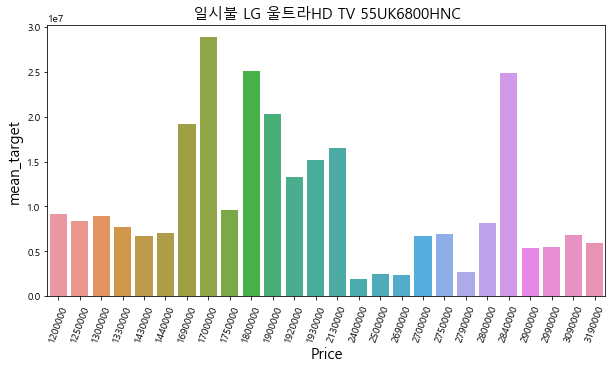

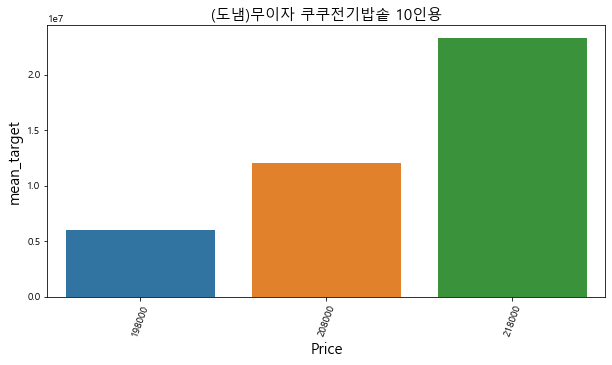

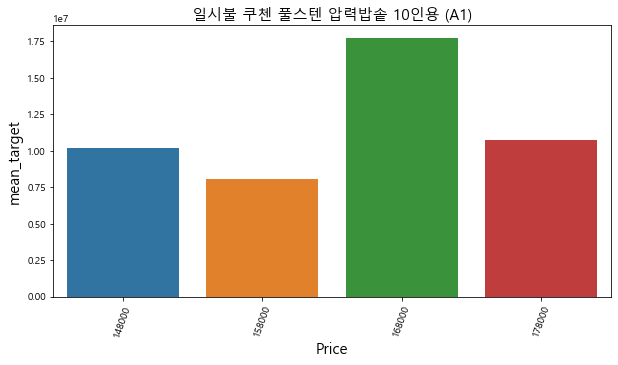

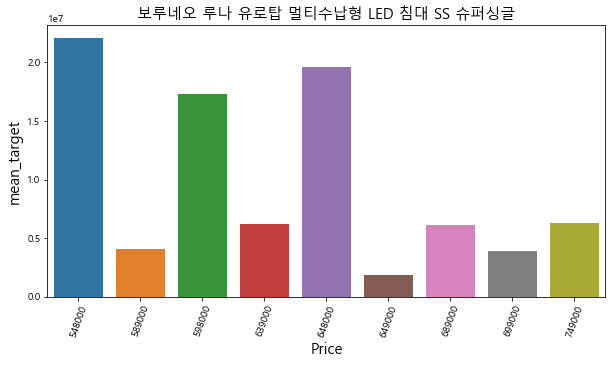

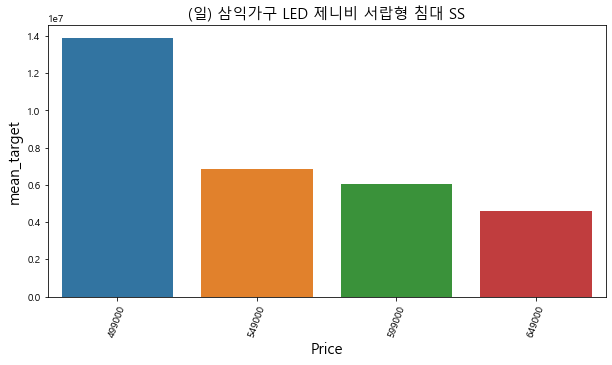

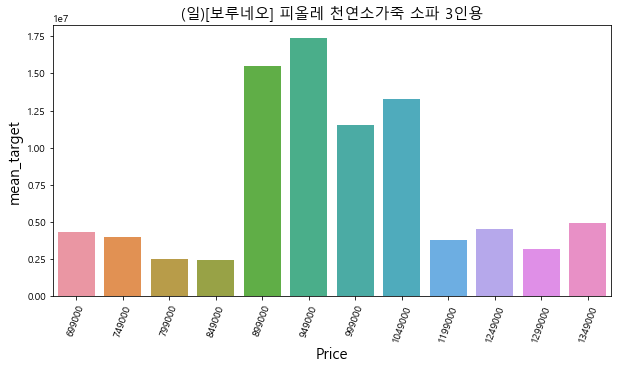

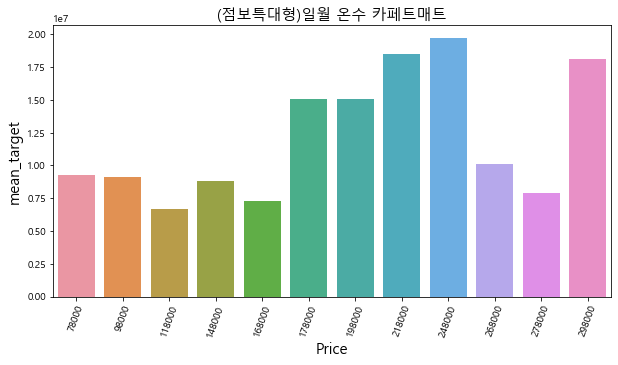

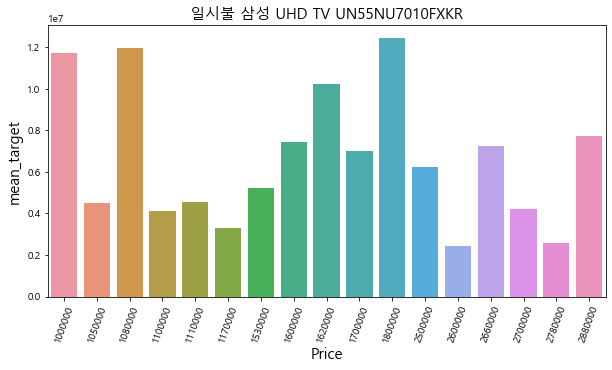

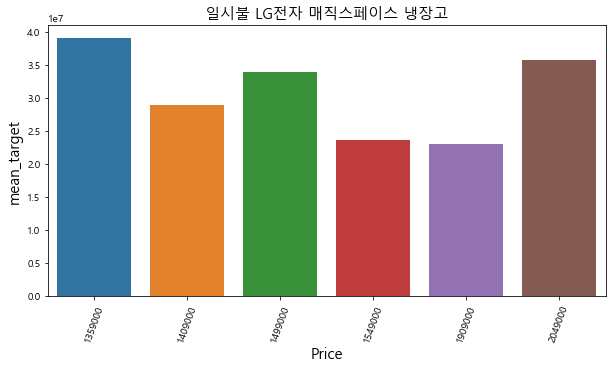

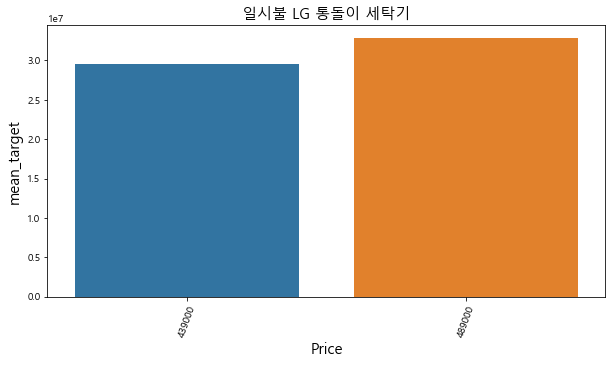

In [50]:
for values in top10_mcode:
    price_target_plot(values)

## 가격과 주문량 plot

In [51]:
def price_orders_plot(mcode):
    a = group_mcode.get_group(mcode)
    b = a.groupby('p_price')
    c = b.orders.mean().sort_values(ascending=False)
    d = train_data[train_data['m_code']==mcode]['p_name'].values[0]
    
    plt.figure(figsize=(10,5))
    sns.barplot(x=c.index, y=c.values)
    plt.title(d, size=15)
    plt.xlabel('Price', size=15)
    plt.ylabel('mean_orders', size=15)
    plt.xticks(rotation=70)

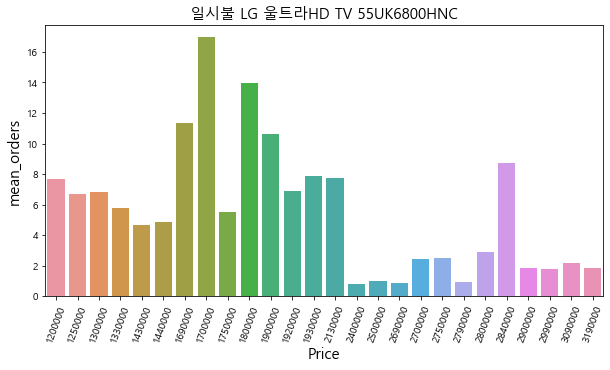

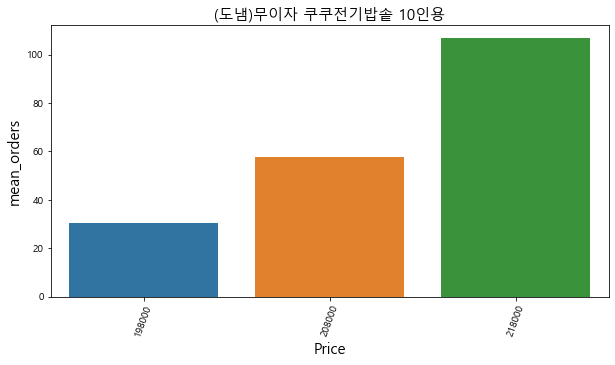

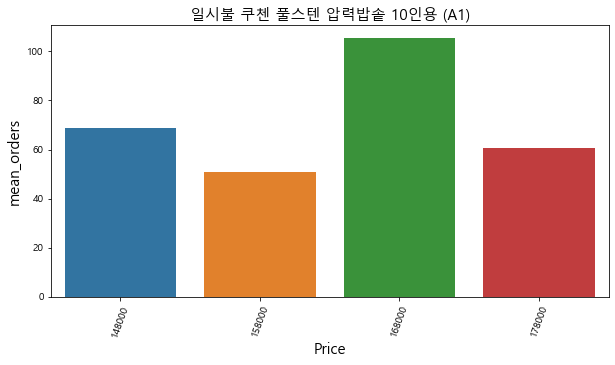

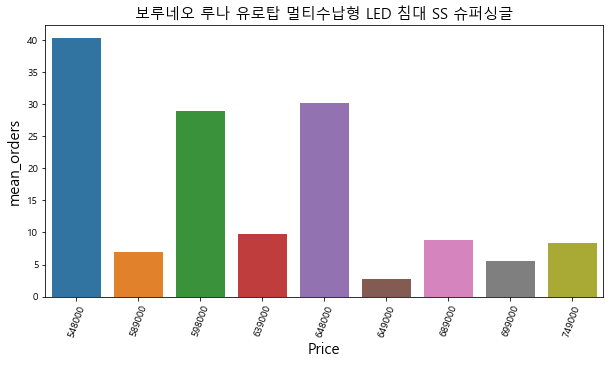

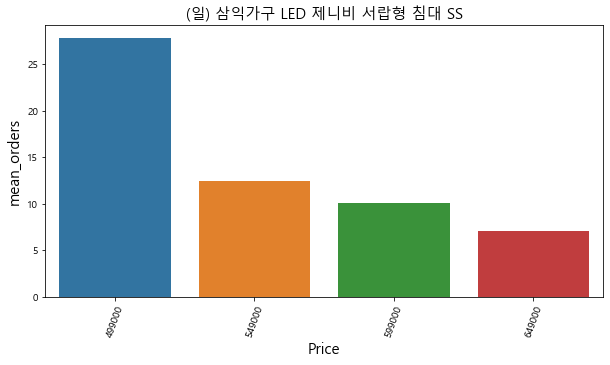

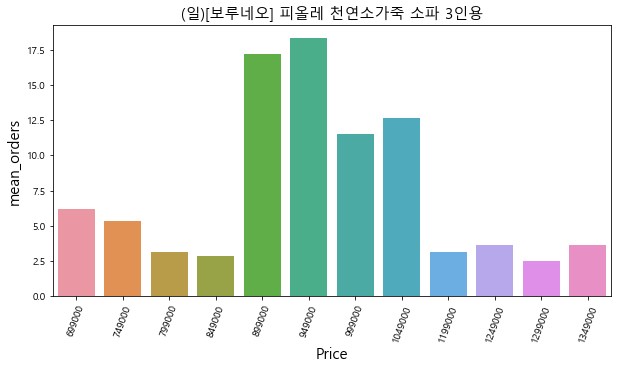

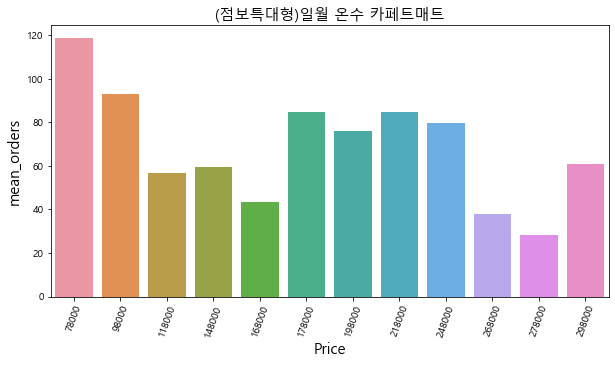

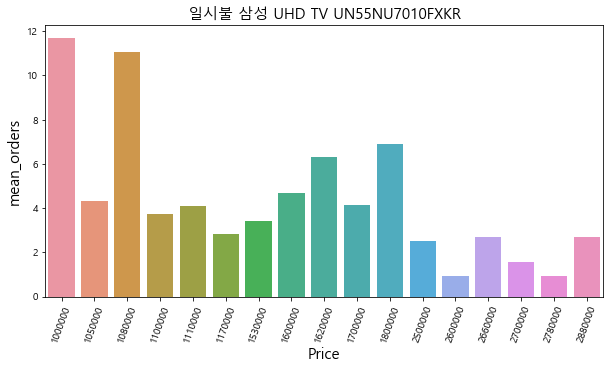

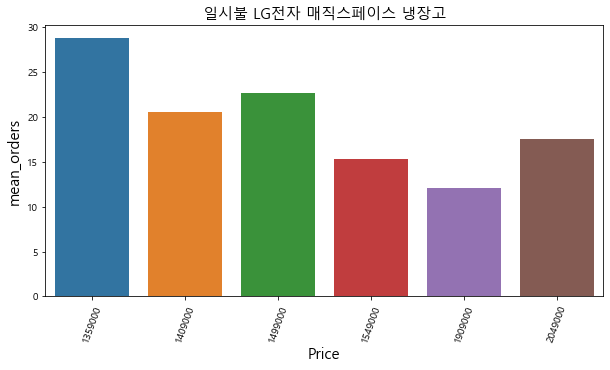

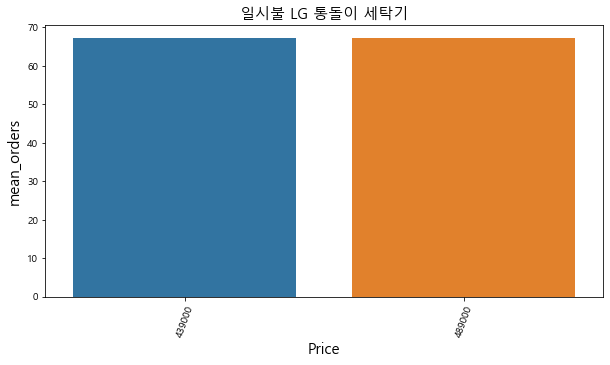

In [73]:
for values in top10_mcode:
    price_orders_plot(values)

In [78]:
cloth_top10_mcode=pd.Series(cloth_top10_mcode(train_data))

TypeError: 'Series' object is not callable

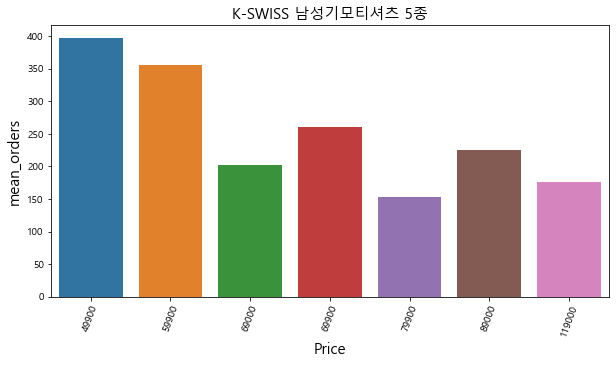

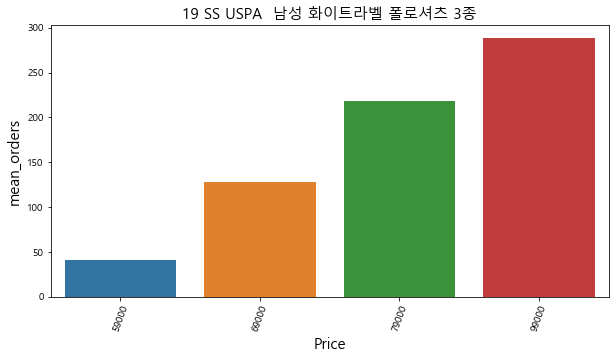

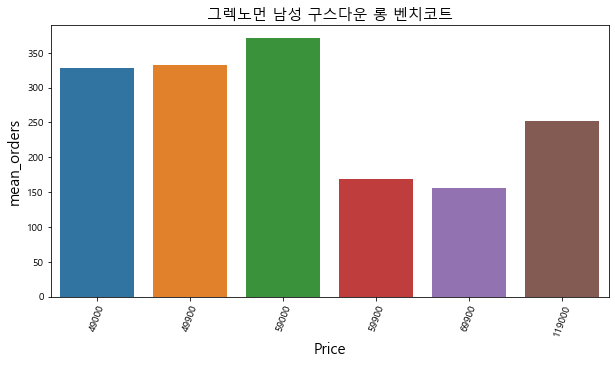

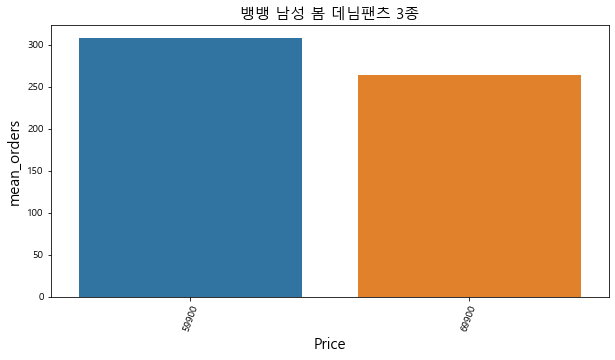

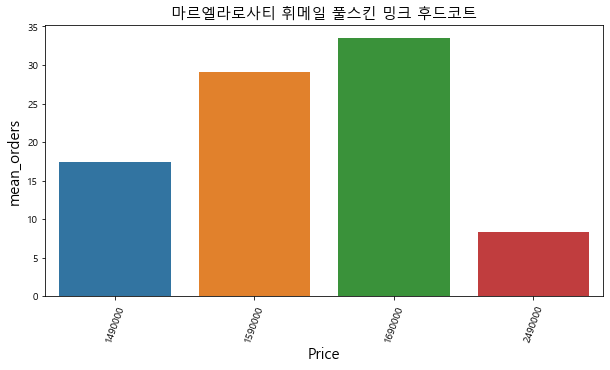

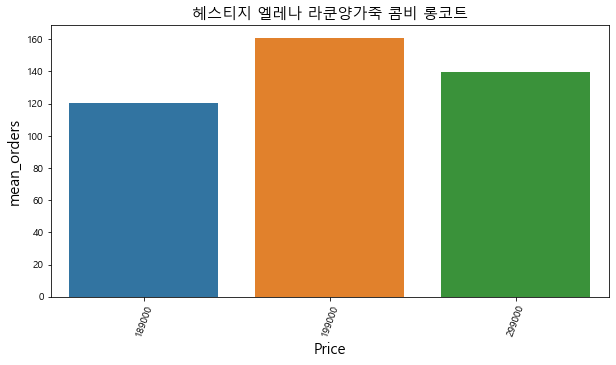

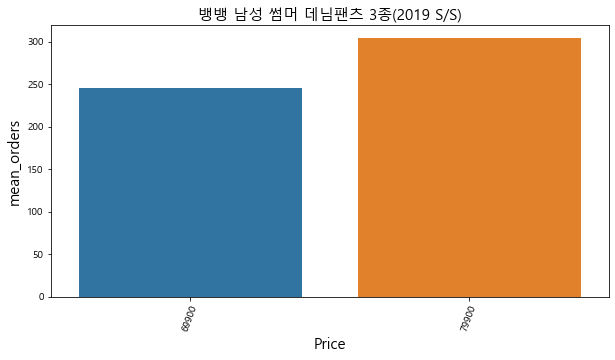

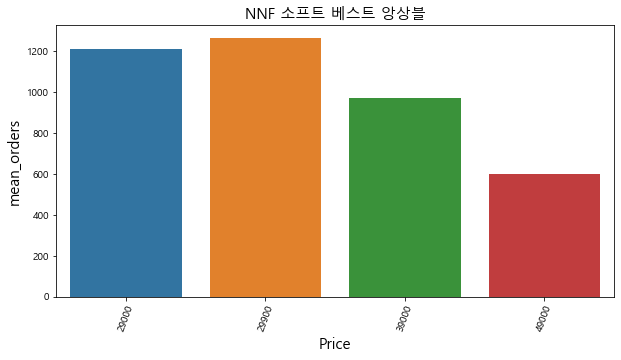

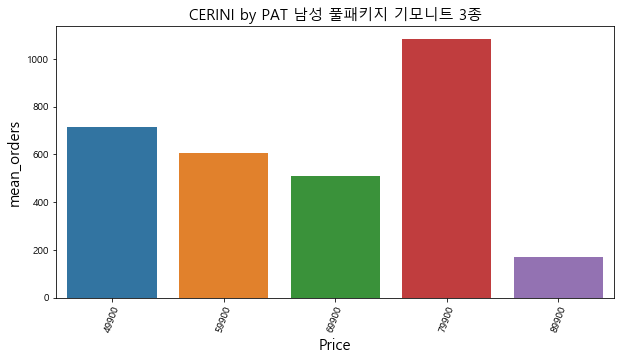

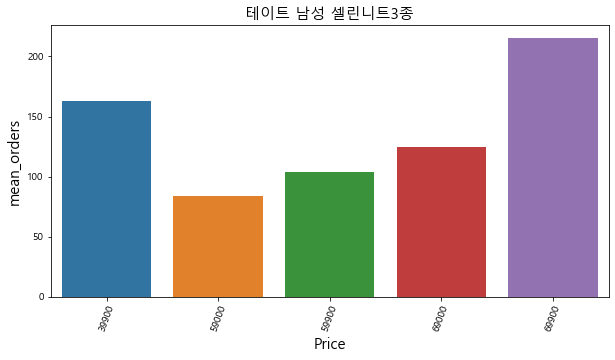

In [64]:
for values in cloth_top10_mcode:
    price_orders_plot(values)